In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal, stats, fftpack
import mplcursors
from glob import glob
import time

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_stim_events, get_events_wdict, qualitycheck_trials

In [5]:
%matplotlib widget

### Functions

#### Plot electrodes

Text(0.5, 1.0, 'NeuroNexus numbering')

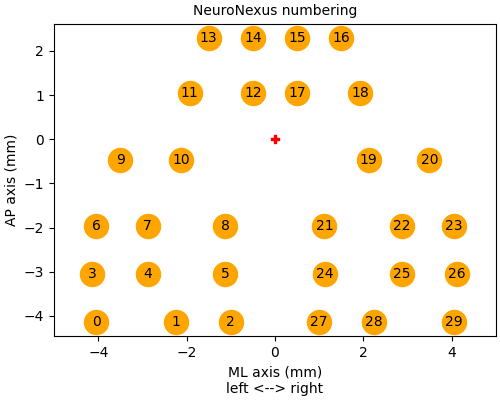

In [6]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

ax.scatter(EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP'], s=300, color='orange')
ax.scatter(0, 0, marker='P', color='red')
ax.axis('equal')
    
for ind in range(len(EEGexp.EEG_channel_coordinates)):
    ax.annotate(str(ind),  xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]), ha='center', va='center', color="k")

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('NeuroNexus numbering')

### Load experiment

In [7]:
recfolder = r'P:\mouse730913\signal_test_2024-04-10_16-12-57\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: sensory stimulation


### Load EEG data and stimulus log

In [8]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

In [9]:
bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [10]:
stim_log = pd.read_csv(exp.stimulus_log_file)
# if 'good' not in stim_log.columns:
#     qualitycheck_trials(exp, known_bad_chs=bad_chs)
#     stim_log = pd.read_csv(exp.stimulus_log_file)

In [11]:
stim_log.head()

,stim_type,parameter,ISI,duration,onset,offset,sweep
0,circle,white,4.453313,0.25,169.63015,169.88062,0
1,circle,white,4.214403,0.25,174.20064,174.45110,0
2,circle,white,4.321758,0.25,178.65435,178.90480,0
3,circle,white,3.916555,0.25,183.22482,183.47529,0
4,circle,white,3.751302,0.25,187.37829,187.62873,0


### Stim evoked traces

In [14]:
plot_before = 0.5 # s, look at 500 ms pre-stim
plot_after = 1.0 # s, look at 1000 ms post-stim
remove_bad_trials = False

## Loop through all stim events/sweeps and collect traces
avg_traces = {}
for st_type in stim_log.stim_type.unique():
    avg_traces[st_type] = {}
    
#     param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].duration.unique())
    for parami in param_list:
        avg_traces[st_type][parami] = {}
        
#         sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['duration']==parami)].sweep.unique())
        for sweepi in sweep_list:
            avg_traces[st_type][parami][sweepi] = {}
            print('{}, {}, sweep {:d}'.format(st_type, str(parami), sweepi))
            ## Get event times ##
            adict = {'stim_type': st_type, 'duration': parami, 'sweep': sweepi}
            events = get_events_wdict(stim_log, adict, out='onset')
#             events = get_stim_events(stim_log, st_type, parami, sweepi, remove_bad_epochs=remove_bad_trials)
            if len(events) == 0:
                print('no good trials found')
                continue
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
            comavg_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            
            ## Design Butterworth bandpass filter ##
            filtb, filta = signal.butter(
                3,
                np.array([0.1, 100])/(exp.ephys_params['EEG']['sample_rate']/2),
                btype='bandpass'
            )
            
            ## Store traces ##
            avg_traces[st_type][parami][sweepi]['raw'] = [event_ts, np.mean(event_traces, axis=2)]
            avg_traces[st_type][parami][sweepi]['filtered'] = [
                event_ts,
                np.mean(signal.filtfilt(filtb, filta, event_traces, axis=0), axis=2)
            ]
            avg_traces[st_type][parami][sweepi]['common_averaged'] = [
                event_ts,
                np.mean(signal.filtfilt(filtb, filta, comavg_traces, axis=0), axis=2)
            ]

circle, 0.25, sweep 0
natural_scene, 0.2, sweep 0
natural_scene, 0.5, sweep 0
natural_scene, 1.0, sweep 0


### Plotting

Plot the visual evoked response across all electrodes. This plots all electrodes in the array layout, with bad chs in red. You can choose to plot:
- 'raw': raw signals, averaged across all trials
- 'filtered': bandpass filtered signals, averaged across all trials
- 'common_averaged': raw signals that have been common average referenced to all good chs, then filtered and averaged across all trials

<IPython.core.display.Javascript object>


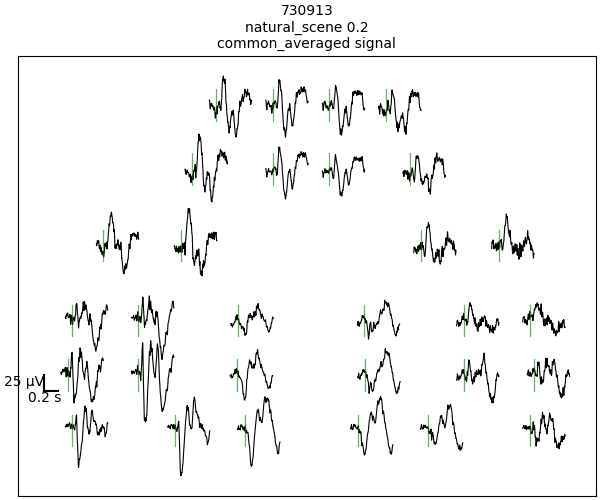

In [20]:
plot_stim_type = 'natural_scene'
plot_stim_param = 0.2
plot_sweep = 0
plot_traces = 'common_averaged' # choose: 'raw', 'filtered', or 'common_averaged'

# if remove_bad_trials:
#     tag = 'good'
# else:
#     tag = 'all'

prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 80 # changes vertical distance between traces, usually 100 for VEPs

timex = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][0]
plottraces = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][1]
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
        continue
    ax.plot(
        timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        trace_color,
        linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
#     ax.plot([0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
#              0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
#             [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
#              25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
#             color='r', linewidth=0.9, alpha=0.6)
    if chi == 3:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.95
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_arrayplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)

## UNCOMMENT TO SAVE THE FIGURE ##
# fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

In [ ]:
snr_dur = 0.2

binds = np.squeeze(np.argwhere((timex >= -snr_dur) & (timex < 0)))
rinds = np.squeeze(np.argwhere((timex > 0) & (timex <= snr_dur)))

base_power = np.mean(np.square(plottraces[binds, :]), axis=0)
resp_power = np.mean(np.square(plottraces[rinds, :]), axis=0)
snrs = np.sqrt(resp_power / base_power)
print(snrs)
print(np.mean(snrs))

#### Same plot above, but as a butterfly plot

<IPython.core.display.Javascript object>


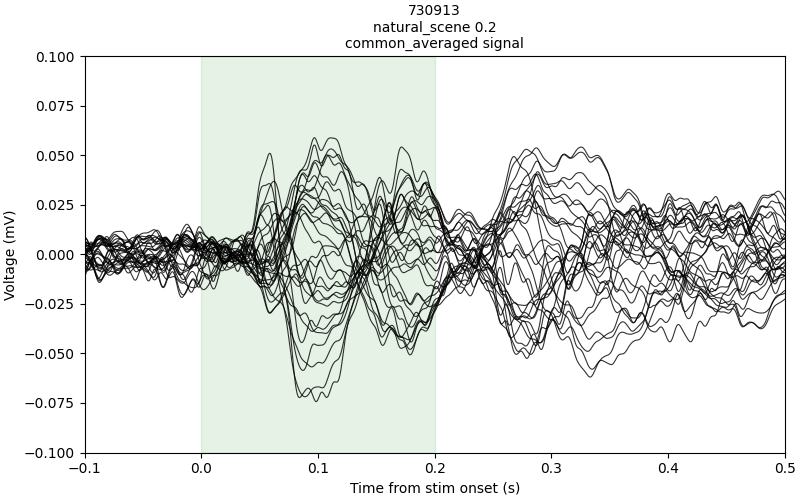

In [21]:
ylimit = 0.1 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
for chi in GOOD_CHS:
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000, color='k', linewidth=0.8, alpha=0.8)
ax.axvspan(0., 0.2, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_butterflyplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
# fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

#### Same plot, but with electrodes vertically stacked

<IPython.core.display.Javascript object>


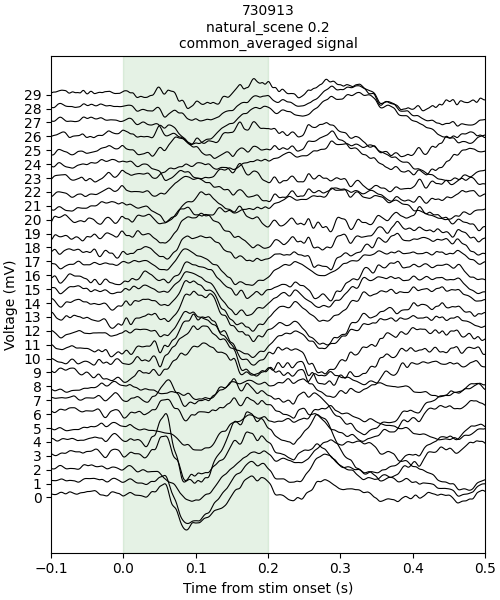

In [22]:
sep = 0.025 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(5, 6), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
        continue
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000 + sep*chi, color=trace_color, linewidth=0.8)
ax.axvspan(0., 0.2, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_xlabel('Time from stim onset (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(range(len(exp.EEG_channel_coordinates)))
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_stackedplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
# fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

### Plot whole traces

<IPython.core.display.Javascript object>


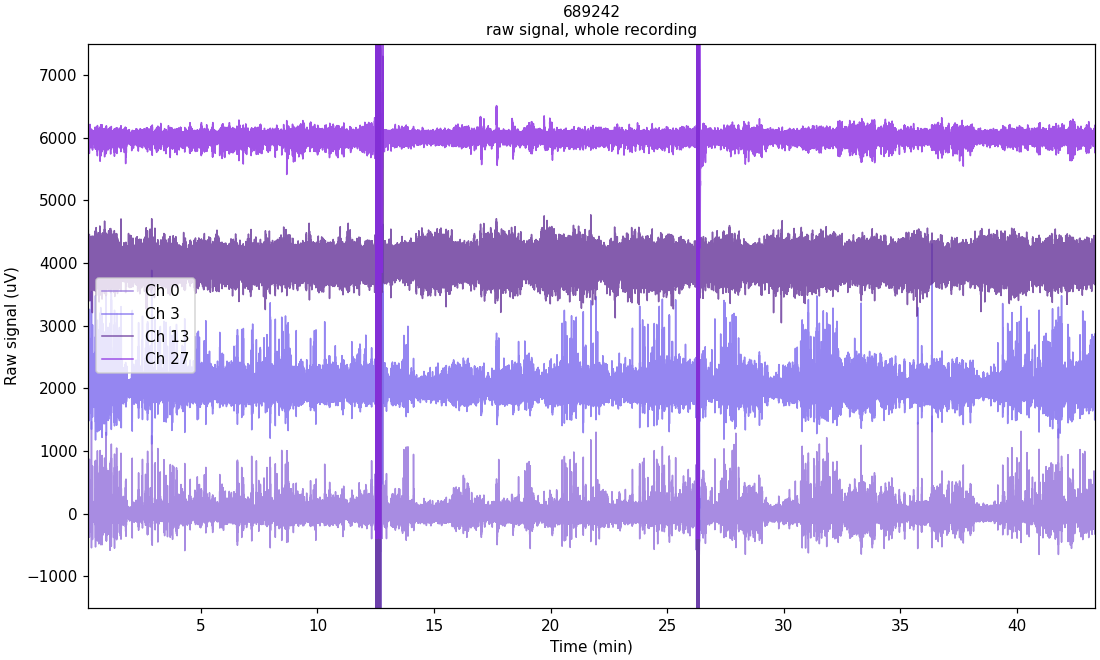

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [17]:
plot_chs = [0,3,13,27]
chcolors = ['mediumpurple','mediumslateblue','rebeccapurple','blueviolet','darkorchid','darkviolet']
# chcolors = ['crimson','blue','gold','green','darkviolet','deeppink']

offset = 2000 # 500
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

for i, chi in enumerate(plot_chs):
    ax.plot(eeg_ts / 60, eeg_data[:,chi] + i*offset, color=chcolors[i], linewidth=1, alpha=0.8, label=('Ch {:d}'.format(chi)))

ax.set_xlim((eeg_ts[0] / 60, eeg_ts[-1] / 60))
ax.set_ylim((-1500, 7500))

ax.set_xlabel('Time (min)')
ax.set_ylabel('Raw signal (uV)')
ax.set_title('{}\nraw signal, whole recording'.format(exp.mouse))
ax.legend()

### SAVE: this will save the figure in the recording1 folder ###
fig_name = 'whole_raw_signals_min.png'
# fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

### Look at spectrum of chs

In [16]:
start_samp = int(300. * exp.ephys_params['EEG']['sample_rate'])
end_samp = start_samp + int(120. * exp.ephys_params['EEG']['sample_rate'])
frex, Pxx = signal.welch(
#     eeg_data[:int(120 * exp.ephys_params['EEG']['sample_rate'])+1, :], # looks at first 120 s
    eeg_data[start_samp:end_samp, :],
    exp.ephys_params['EEG']['sample_rate'],
    nperseg=2 * exp.ephys_params['EEG']['sample_rate'],
    axis=0
)

<IPython.core.display.Javascript object>


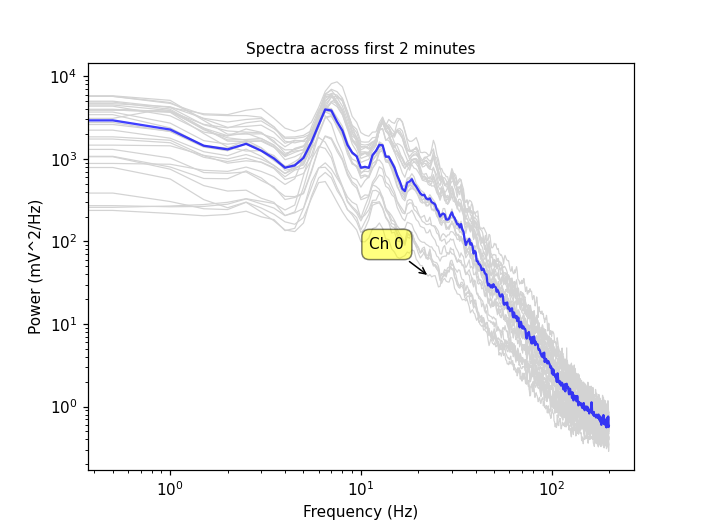

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [17]:
frinds = frex < 200

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(ind))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
# ax.set_xlim([0, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')

In [18]:
bad_chs = []
print(bad_chs)
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
BAD_CHS = np.array(bad_chs)

[]


<IPython.core.display.Javascript object>


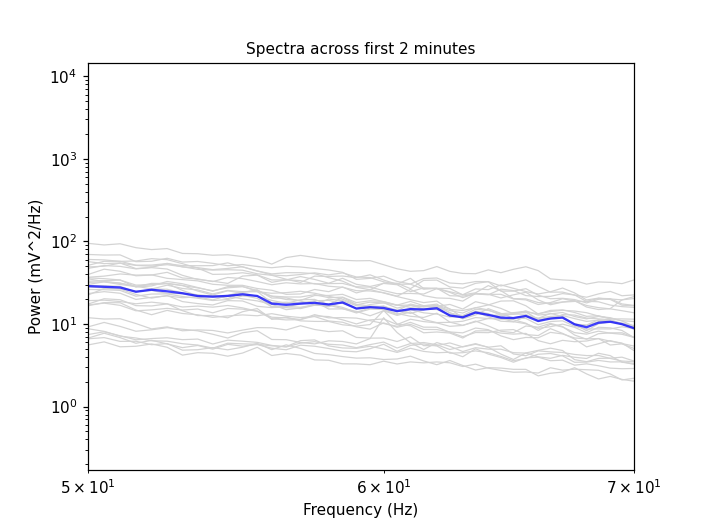

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [19]:
fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:][:,GOOD_CHS], color='lightgray', linewidth=0.8)
if BAD_CHS.size > 0:
    ax.loglog(frex[frinds], Pxx[frinds,:][:,BAD_CHS], color='r', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(GOOD_CHS[ind]))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx[:,GOOD_CHS], axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([50, 70])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')